NOTE: to obtain the most recent version of this notebook, please copy from 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1U3fkRu6-hwjk7wWIpg-iylL2u5T9t7rr#scrollTo=lsT4-_Eq45Ww)


## **Training Faster R-CNN Object Detection on a Custom Dataset**

### **Overview**

This notebook walks through how to train a Faster R-CNN object detection model using the TensorFlow Object Detection API.

In this specific example, we'll training an object detection model to recognize cells types: white blood cells, red blood cells and platelets. **To adapt this example to train on your own dataset, you only need to change two lines of code in this notebook.**

Everything in this notebook is also hosted on this [GitHub repo](https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn).

![Blood Cell Example](https://i.imgur.com/QwyX2aD.png)

**Credit to [DLology](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) and [Tony607](https://github.com/Tony607)**, whom wrote the first notebook on which much of this is example is based. 

### **Our Data**

We'll be using an open source cell dataset called BCCD (Blood Cell Count and Detection). Our dataset contains 364 images (and 4888 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/bccd).

When adapting this example to your own data, create two datasets in Roboflow: `train` and `test`. Use Roboflow to generate TFRecords for each, replace their URLs in this notebook, and you're able to train on your own custom dataset.

### **Our Model**

We'll be training a Faster R-CNN neural network. Faster R-CNN is a two-stage detector: first it identifies regions of interest, and then passes these regions to a convolutional neural network. The outputted features maps are passed to a support vector machine (SVM) for classification. Regression between predicted bounding boxes and ground truth bounding boxes are computed. (Consider [this](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a) deep dive for more!)

The model arechitecture is one of many available via TensorFlow's [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models).

### **Training**

Google Colab provides free GPU resources. Click "Runtime" → "Change runtime type" → Hardware Accelerator dropdown to "GPU."

Colab does have memory limitations, and notebooks must be open in your browser to run. Sessions automatically clear themselves after 12 hours.

### **Inference**

We'll run inference directly in this notebook, and on three test images contained in the "test" folder from our GitHub repo. 

When adapting to your own dataset, you'll need to add test images to the `test` folder located at `tensorflow-object-detection/test`.

### **About**

[Roboflow](https://roboflow.ai) makes managing, preprocessing, augmenting, and versioning datasets for computer vision seamless.

Developers reduce 50% of their boilerplate code when using Roboflow's workflow, automate labelling quality assurance, save training time, and increase model reproducibility.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)







In [ ]:
!pip install tensorflow_gpu==1.15

     |████████████████████████████████| 411.5MB 44kB/s 
     |████████████████████████████████| 512kB 35.1MB/s 
     |████████████████████████████████| 3.8MB 42.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=612ce0d12e28dec4b510521553503fd9d913c65b95c052e217a67f5c49f55973
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninst

## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [ ]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 10000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `tensorflow-object-detection` repository or your fork.

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.84 MiB | 6.68 MiB/s, done.
Resolving deltas: 100% (413/413), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


In [ ]:
!pip install tf_slim

     |████████████████████████████████| 358kB 14.2MB/s 


## Install required packages

In [ ]:
%cd /content

!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [ ]:
# UPDATE THIS LINK - get our data from Roboflow
!curl -L "https://app.roboflow.ai/ds/bfLPtwzQ6U?key=44PdurUZv7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1061      0 --:--:-- --:--:-- --:--:--  1060
100 6410k  100 6410k    0     0  2784k      0  0:00:02  0:00:02 --:--:-- 13.7M
Archive:  roboflow.zip
 extracting: test/building.tfrecord  
 extracting: train/building.tfrecord  
 extracting: valid/building.tfrecord  
 extracting: test/building_label_map.pbtxt  
 extracting: train/building_label_map.pbtxt  
 extracting: valid/building_label_map.pbtxt  
 extracting: README.roboflow.txt     


In [ ]:
%ls

FYI.txt  README.roboflow.txt  test/  train/  valid/


In [ ]:
# check out what we have in train
%ls train

building_label_map.pbtxt  building.tfrecord


In [ ]:
# show what we have in test
%ls test

building_label_map.pbtxt  building.tfrecord


In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/valid/building.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/building.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/building_label_map.pbtxt'

## Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 63 root   root 4.0K Jul 13 22:15 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-07-13 22:17:19--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.238.5.126, 34.225.3.211, 34.227.164.168, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.238.5.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  4.93MB/s    in 2.7s    

2020-07-13 22:17:23 (4.93 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://d228839f0d03.ngrok.io


## Train the model

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0713 22:18:15.539822 140307214522240 model_lib.py:758] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0713 22:18:15.540057 140307214522240 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0713 22:18:15.540172 140307214522240 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0713 22:18:15.540274 140307214522240 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0713 22:18:15.540416 140307214522240 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0713 22:18:15.540560 140307214522240 model_lib.py:774] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1594678733.a701962e31fb
export
graph.pbtxt
model.ckpt-10000.data-00000-of-00001
model.ckpt-10000.index
model.ckpt-10000.meta
model.ckpt-7571.data-00000-of-00001
model.ckpt-7571.index
model.ckpt-7571.meta
model.ckpt-8201.data-00000-of-00001
model.ckpt-8201.index
model.ckpt-8201.meta
model.ckpt-8831.data-00000-of-00001
model.ckpt-8831.index
model.ckpt-8831.meta
model.ckpt-9461.data-00000-of-00001
model.ckpt-9461.index
model.ckpt-9461.meta


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-10000
Instructions for updating:
Please use `layer.__call__` method instead.
W0714 00:59:15.401624 140320499443584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0714 00:59:16.800354 140320499443584 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0714 00:59:16.814411 140320499443584 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0714 00:59:16.814757 140320499443584 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0714 00:59:16.868257

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 50M Jul 14 00:59 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1SP9Ns5qEyyVdACAxpfzfYLmVBtnpZu4c


### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
from google.colab import files
files.download(pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test

To test on your own images, you need to upload raw test images to the `test` folder located inside `/data`.

Right now, this folder contains TFRecord files from Roboflow. We need the raw images.


#### Add test images to this notebook

We can download the exact same raw images that are in our Roboflow test split to our local computer by downloading the images in a different (non-TFRecord) format.

Go back to our [dataset](https://public.roboflow.ai/object-detection/bccd/1), click "Download," select "COCO JSON" as the format, and download to your local machine.

Unzip the downloaded file, and navigate to the `test` directory.
![folder](https://i.imgur.com/xkjxmKP.png)


Now, on the left-hand side in the colab notebook, select the folder icon.
![Colab folder](https://i.imgur.com/59v08qG.png)

Right-click on `test`, and select "Upload." Navigate to the files locally on your machine you just downloaded...and voila! You're set!


In [ ]:
!pwd

/content/models/research


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ln -s /content/drive/My\ Drive/ /mydrive

In [ ]:
!ls /mydrive

 171230011.pdf
'air force'
 ambuj
 Ambuj_CV_Org.pdf
'CBSE - JOINT ENTRANCE EXAMINATION (MAIN) - 2017.pdf'
 Cert
 CNN
'Colab Notebooks'
'Copy of 16MAR08101213-P3DS-055675519050_01_P001.png'
'Copy of 16MAR08101213-P3DS-055675519050_01_P001.TIF'
 CP.pdf
 cross_effects_table_TRUNCATED.csv
 dc_to_the_edge.zip
 deep_learning_time_series_forecasting.pdf
'dim_table (1).gsheet'
'dim_table (2).gsheet'
 dim_table.gsheet
'Document from Ambuj Mishra.pdf'
 domesile.pdf
'Farming Plan.gdoc'
 Fine.pdf
 FRCNN
 frozen_inference_graph.pb
'Get in Touch .gform'
 INCOME2018.pdf
 master_file.gsheet
 ML_Resource.gdoc
'New Doc 2018-07-24 (4).pdf'
'New Doc 2018-07-28.pdf'
'New Doc 2018-08-12 - Page 1.jpg'
'New Doc 2019-01-18 14.06.25_1.jpg'
'New Doc 2019-01-18 14.06.25_2.jpg'
 Paramveer
 Power_sri
 Sachin_sir
'sem2 (1).jpg'
 sem2.jpg
 Summary
 task_data
 Tripoli_zipped
 Untitled
 Untitled0.ipynb
'Untitled (1)'
'Untitled form.gform'
'Untitled spreadsheet.gsheet'
 Yolo
 yolov3
 YOLOv3_copy_for_Ambuj.ipynb
 Youtube

In [ ]:
#!rm -rf /content/tensorflow-object-detection-faster-rcnn/data/test

In [ ]:
#!cp -R /mydrive/Tripoli_zipped/Yolo/test /content/tensorflow-object-detection-faster-rcnn/data/

In [ ]:
# optionally, remove the TFRecord and cells_label_map.pbtxt from
# the test directory so it is only raw images
%cd {repo_dir_path}
%cd data/test
%rm building.tfrecord
%rm building_label_map.pbtxt

/content/tensorflow-object-detection-faster-rcnn
/content/tensorflow-object-detection-faster-rcnn/data/test
rm: cannot remove 'building.tfrecord': No such file or directory
rm: cannot remove 'building_label_map.pbtxt': No such file or directory


In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/data/test/row-7-col-3.png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-6-col-6.png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-6-col-4 (1).png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-6-col-5.png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-5-col-5 (1).png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-5-col-7.png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-7-col-4.png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-5-col-6 (1).png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-9-col-9.png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-9-col-3.png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-7-col-3 (1).png', '/content/tensorflow-object-detection-faster-rcnn/data/test/row-10-col-4.png', '/content/tensorflow-object-detection-faster-r

In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    red, green, blue, X = image.split()
    import numpy as np
    r = np.array(red)
    g = np.array(green)
    b = np.array(blue)
    rgb = np.dstack((r,g,b))
    image = Image.fromarray(rgb)
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8) #0.5
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

In [ ]:
TEST_IMAGE_PATHS

['/content/tensorflow-object-detection-faster-rcnn/data/test/row-7-col-3.png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-6-col-6.png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-6-col-4 (1).png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-6-col-5.png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-5-col-5 (1).png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-5-col-7.png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-7-col-4.png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-5-col-6 (1).png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-9-col-9.png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-9-col-3.png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-7-col-3 (1).png',
 '/content/tensorflow-object-detection-faster-rcnn/data/test/row-10-col-4.png',
 '/content/tensorflow-object-detect

In [ ]:

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

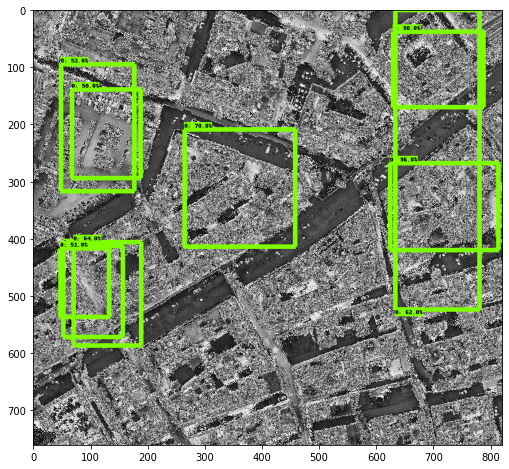

In [109]:
image = Image.open('/content/tensorflow-object-detection-faster-rcnn/data/test/row-4-col-8.png')
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)